In [1]:
import keras 
from keras import layers
from keras.layers import Embedding, Dropout, Dense, LSTM, Bidirectional, Input, Dense, Flatten
from keras.models import Sequential, Model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from sklearn.metrics import precision_recall_fscore_support as score
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np 
from tqdm import tqdm_notebook as tqdm
import json
import pandas as pd 
import os

Using TensorFlow backend.
/Users/sichenglei/Desktop/kaggle/salt/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)

Bad key "ckend" on line 1 in
/Users/sichenglei/.matplotlib/matplotlibrc.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution
/Users/sichenglei/Desktop/kaggle/salt/venv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [20]:
def data_loader(file):
    with open(file, 'r') as f:
        sents = []
        labels = []
        for line in f:
            line = line.strip().split()
            labels.append(int(line[2]))
            sents.append(' '.join(line[4:]))
    return sents, labels

In [21]:
train_sents, train_labels = data_loader("../../data/train.txt")
val_sents, val_labels = data_loader("../../data/validate.txt")
test_sents, test_labels = data_loader("../../data/test.txt")

In [8]:
data_set = pd.read_json('../../../train_test/data_sets.json', encoding='utf-8')
#note: dataset_id = index + 1
data_description = data_set["description"].values


In [9]:
# Add a sentence for no mention case
data_description = list(data_description)
data_description.insert(0, "There is no mention.")

In [30]:
maxlen = 100
vocab_size = 40000 ##more than 80K unique tokens
EMB_DIM = 50
HIDDEN_DIM = 256
EPOCHS = 5  ## train more epochs with GPU, it takes 1h per epoch on my CPU
NEG_RATIO = 3
BATCH_SIZE = 10
DATASET_CLASS = len(data_description) 
MODEL_NAME = "LSTM"

#actual batch size = BATCH_SIZE * (1 + NEG_RATIO)

In [26]:
DATASET_CLASS

10349

In [31]:
###NOT using dataset info anymore
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_sents)
X_train = tokenizer.texts_to_sequences(train_sents)
X_val = tokenizer.texts_to_sequences(val_sents)
X_test = tokenizer.texts_to_sequences(test_sents)

word_index = tokenizer.word_index
print ("Found %s unique tokens."%len(word_index))

Found 45910 unique tokens.


In [32]:
X_train = pad_sequences(X_train, maxlen=maxlen)
X_val = pad_sequences(X_val, maxlen=maxlen)
X_test = pad_sequences(X_test, maxlen=maxlen)
Y_train = np.asarray(train_labels)
Y_val = np.asarray(val_labels)
Y_test = np.asarray(test_labels)
Y_train = keras.utils.to_categorical(Y_train, num_classes=DATASET_CLASS)
Y_val = keras.utils.to_categorical(Y_val, num_classes=DATASET_CLASS)
Y_test = keras.utils.to_categorical(Y_test, num_classes=DATASET_CLASS)

In [34]:
##randomly shuffle data and labels
##np.random.seed(0)
N = X_train.shape[0]
indices = np.arange(N)
np.random.shuffle(indices)
X_train = X_train[indices]
Y_train = Y_train[indices] 

In [35]:
## I am not using Glove here, may get better results with Glove
vocab_size = len(word_index) + 1
def build_model():
    embedding_layer = Embedding(vocab_size, EMB_DIM, input_length=maxlen)
    article_input = Input(shape=(maxlen,), dtype='int32')
    article_emb = embedding_layer(article_input)
    
    article_lstm = LSTM(HIDDEN_DIM, dropout=0.2, recurrent_dropout=0.3)
    article_vector = article_lstm(article_emb)
    #vector shape: (batch_size, hidden_dim)
    
    dense_vector = Dense(HIDDEN_DIM*4)(article_vector)
    
    dense_vector = Dropout(0.3)(dense_vector)
    output = Dense(DATASET_CLASS)(dense_vector)
    
    model = Model(article_input, output)
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model 


In [36]:
model = build_model()

In [37]:
history = model.fit(X_train, Y_train, 
                    epochs=EPOCHS,
                    batch_size=128,
                    validation_data=(X_val, Y_val))

Train on 30208 samples, validate on 4196 samples
Epoch 1/5
30208/30208 [==============================] - 380s 13ms/step - loss: 9.9903 - acc: 0.0246 - val_loss: 8.3314 - val_acc: 0.0553
Epoch 2/5
30208/30208 [==============================] - 352s 12ms/step - loss: 13.0976 - acc: 0.0513 - val_loss: 15.9965 - val_acc: 0.0553
Epoch 3/5
30208/30208 [==============================] - 354s 12ms/step - loss: 16.0052 - acc: 0.0513 - val_loss: 15.9796 - val_acc: 0.0553
Epoch 4/5
30208/30208 [==============================] - 376s 12ms/step - loss: 15.9957 - acc: 0.0513 - val_loss: 15.9731 - val_acc: 0.0553
Epoch 5/5
30208/30208 [==============================] - 362s 12ms/step - loss: 15.9898 - acc: 0.0513 - val_loss: 15.9688 - val_acc: 0.0553


In [27]:
model.save("baseline.h5")

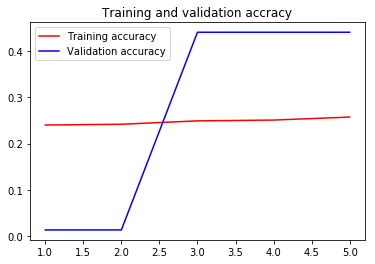

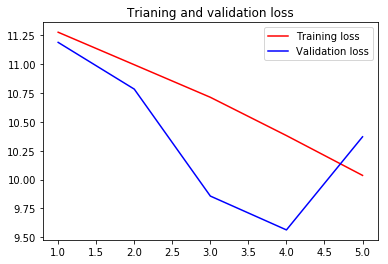

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(acc)+1)

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Trianing and validation loss')
plt.legend()

plt.show()

In [38]:
model.evaluate(X_test, Y_test)

3356/3356 [==============================] - 11s 3ms/step


[15.967442291996335, 0.05154946364719905]

In [ ]:
##test accuracy: 0.469 